# Durban Port Congestion Simulation
### **Discrete event simulation of Crane Scheduling & Yard Dwell Time**

This notebook models the flow of containers through the Durban Container Terminal using a Discrete Event Simulation (DES) approach.
The goal is to:

- Identify bottlenecks
- Model realistic delays
- Test optimisation strategies such as:
    1. Crane Scheduling Optimisation
    2. Yard Dwell Time Reduction

This notebook is structured to reflect the real-world operations of Durban Port, including:

- Offloading by STS cranes
- Yard capacity constraints
- Scanning delays (SARS)
- Truck loading
- Gate-out processing

We will build the simulation step-by-step, with explanations for each block.

In [37]:
import simpy
import random
import numpy as np
import pandas as pd

Listed above, are the core libraries for our simulation:
- simpy : Discrete event simulation engine
- random : Stochastic arrival patterns
- numpy : numerical operations
- pandas : storing and analysing the results

This is the minimal set we need to start building our model.

In [38]:
# -----------------------------
# Global Parameters (Week 1 Data + Realistic Behaviour Enhancements)
# -----------------------------

# Cranes (STS)
NUM_CRANES = 16         
CRANE_MOVES_PER_HOUR = 18   
CRANE_TIME = 60 / CRANE_MOVES_PER_HOUR  

# Yard
YARD_CAPACITY = 10000  

# Scanners (SARS)
NUM_SCANNERS = 2    
SCAN_TIME = 10       # fixed scanning time (we keep this deterministic)

# --------------------------------------------------------
# Truck Loading (realistic: fewer bays + variable service)
# --------------------------------------------------------
NUM_LOADING_BAYS = 2     # reduced to induce realistic queueing

import random

def sample_loading_time():
    # triangular distribution: min=20, mode=30, max=40 minutes
    return random.triangular(20, 30, 40)

# --------------------------------------------------------
# Gate-Out (realistic: fewer lanes + variable service)
# --------------------------------------------------------
NUM_GATE_LANES = 1       # reduced from 4 to induce queueing

def sample_gate_time():
    # triangular distribution: min=5, mode=8, max=15 minutes
    return random.triangular(5, 8, 15)

# --------------------------------------------------------
# Simulation duration
# --------------------------------------------------------
SIM_TIME = 7 * 24 * 60  # 7 days in minutes  

# Dwell and post-processing buffers
MAX_DWELL = 7 * 24 * 60        
POST_PROCESS_BUFFER = 6 * 60   


These parameters used above come from Week 1 of the analysis:
- Crane productivity: 18 moves/hour
- Scanning: 2 scanners, 10 minutes per container
- Yard dwell: capacity-constrained (we will add dwell logic later)
- Truck loading: 20 bays at Pier 2
- Gate-out: 4 lanes
- Simulation time: 7 days (long enough to show congestion)

These variables make the model easy to modify once we begin optimisation experiments.

# Metrics Storage

In [39]:
# -----------------------------------------
# Metrics Storage
# -----------------------------------------

METRICS = []

def reset_metrics():
    """Clear collected metrics between simulation runs."""
    METRICS.clear()     # reset the metrics list so that old results don't mix with new ones

def record_metrics(container_id, timestamps):
    """Append a metrics row for one container."""
    data = {"container_id": container_id}  # create a dictionary for each container with its container ID
    data.update(timestamps)  # add the timestamps to the dictionary => data = {'container_id': #4532, 'arrival': ..., 'crane_start': ..., ...}
    METRICS.append(data)  # append the dictionary to the global METRICS list


**What this does**
- Holds a global `METRICS` list for all container records.
- `reset_metrics()` clears previous runs before starting a new simulation.
- `record_metrics()` copies the timestamp dictionary into the metrics store with `container_id`.


### Container Process

In [40]:
# -----------------------------------------
# Container Process (with Timestamps)
# -----------------------------------------

def container_process(env, container_id, cranes, yard, scanners, loaders, gates):
    """Full lifecycle with timestamp tracking."""
    t = {}
    t["arrival_time"] = env.now

    # 1. Crane Offloading
    with cranes.request() as req:
        yield req
        t["crane_start"] = env.now
        yield env.timeout(CRANE_TIME)
        t["crane_end"] = env.now

    # 2. Yard Entry
    yard_req = yard.put(1)
    yield yard_req
    t["yard_entry_time"] = env.now

    # 3. Yard Dwell
    dwell_time = random.choice([3*24*60, 5*24*60, 7*24*60])
    yield env.timeout(dwell_time)
    t["yard_exit_time"] = env.now

    # 4. Scanning
    with scanners.request() as req:
        t["scan_queue_enter"] = env.now
        yield req
        t["scan_start"] = env.now
        yield env.timeout(SCAN_TIME)
        t["scan_end"] = env.now

    # 5. Truck Loading (now realistic + variable)
    with loaders.request() as req:
        t["loading_queue_enter"] = env.now
        yield req
        t["loading_start"] = env.now
        loading_time = sample_loading_time()
        yield env.timeout(loading_time)
        t["loading_end"] = env.now

    # free yard slot once container leaves on truck
    yield yard.get(1)

    # 6. Gate-Out (now realistic + variable)
    with gates.request() as req:
        t["gate_queue_enter"] = env.now
        yield req
        t["gate_start"] = env.now
        gate_time = sample_gate_time()
        yield env.timeout(gate_time)
        t["exit_time"] = env.now

    record_metrics(container_id, t)




**1. Crane Offloading**

The container waits for an available STS crane (SimPy `Resource`).  
Once assigned, the crane takes `CRANE_TIME` minutes to offload the container.


**2. Yard Entry**

The yard is a capacity-limited `simpy.Container`.  
`yard.put(1)` means:  
â†’ the container occupies one slot in the yard.  

If the yard is full, the container waits in the yard entry queue until space becomes available.


**3. Yard Dwell**

The container stays in the yard for a dwell period.  
For now this is a placeholder random value (3, 5, or 7 days).  

Later, this will be replaced with:
- actual Pier 1 and Pier 2 dwell times  
- optimisation experiments that reduce dwell time


**4. Scanning**

The container waits for an available scanner (only 2 scanners exist).  
The scanning process takes about **10 minutes** per container.


**5. Truck Loading**

After scanning, the container waits for a truck loading bay.  
Once assigned, loading takes **about 77 minutes**, including retrieval, positioning, and loading operations.


**6. Gate-Out**

The container waits for a free gate lane.  
Gate processing and document validation take about **7 minutes** per truck.


### Arrival Generator

In [41]:
# --------------------------------------------------------------
# Arrival Generator
# (Generates containers arriving at the port until a stop time)
# --------------------------------------------------------------


def arrival_generator(env, cranes, yard, scanners, loaders, gates, stop_time):
    """Generates containers until stop_time, then lets the system drain."""
    container_id = 0        # each new container gets a unique ID
    while True:             # keep generating containers until stop_time (where I'll break the loop)
        interarrival = random.expovariate(1/5)  # ~1 every 5 minutes    # average interarrival time of 5 minutes (time varies randomly - sometimes 1 minute and sometimes 9, but 5 average)
        yield env.timeout(interarrival)  # wait for the next container arrival
        if env.now >= stop_time:    # check if we've reached the stop time
            break       # stop generating new containers since we've hit the stop time
        env.process(
            container_process(env, container_id, cranes, yard, scanners, loaders, gates) # a new container has arrived, now we simulate its full journey through the port in parallel with others
        )
        container_id += 1   # increment the container ID for the next container


**What this does**
- Creates containers with an exponential interarrival time (~1 every 5 minutes).
- Stops injecting new containers once `stop_time` (SIM_TIME) is reached.
- Each new container process is launched with the current resources and unique `container_id`.


### Initialise Simulation Environment

In [42]:
# -----------------------------------------
# Initialise Simulation Environment
# -----------------------------------------

# Fresh metrics for this run
reset_metrics()

# Create SimPy environment (the simulation clock that schedules all events)
env = simpy.Environment()

# Define shared resources
cranes = simpy.Resource(env, capacity=NUM_CRANES)
yard = simpy.Container(env, capacity=YARD_CAPACITY, init=0) # yard content is initialized to 0
scanners = simpy.Resource(env, capacity=NUM_SCANNERS)
loaders = simpy.Resource(env, capacity=NUM_LOADING_BAYS)
gates = simpy.Resource(env, capacity=NUM_GATE_LANES)

# Start arrival generator until SIM_TIME
env.process(arrival_generator(env, cranes, yard, scanners, loaders, gates, stop_time=SIM_TIME))

# Run simulation long enough to drain (arrivals stop at SIM_TIME)
print("Starting simulation...")
env.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)
print("Simulation complete.")

Starting simulation...
Simulation complete.


**What this does**
- Resets metrics for a fresh run.
- Builds the SimPy environment and shared resources (cranes, yard, scanners, loaders, gates).
- Starts the arrival generator until `SIM_TIME`, then runs long enough (`SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER`) for all in-system containers to finish and record `exit_time`.


### Metric Helpers

In [43]:
def metrics_to_dataframe():
    """Convert collected metrics into a pandas DataFrame with derived fields."""
    if not METRICS:
        return pd.DataFrame()

    # Keep only containers that completed processing
    completed = [m for m in METRICS if "exit_time" in m]
    if not completed:
        return pd.DataFrame()

    df = pd.DataFrame(completed)

    # Core durations
    df["total_time"] = df["exit_time"] - df["arrival_time"]
    df["yard_dwell"] = df["yard_exit_time"] - df["yard_entry_time"]

    # Queue waits (correct definitions)
    df["scan_wait"] = df["scan_start"] - df["scan_queue_enter"]
    df["loading_wait"] = df["loading_start"] - df["loading_queue_enter"]
    df["gate_wait"] = df["gate_start"] - df["gate_queue_enter"]

    # Clip negatives (should never happen, but good safety)
    for col in ["scan_wait", "loading_wait", "gate_wait"]:
        df[col] = df[col].clip(lower=0)

    return df


**What this does**
- Converts collected `METRICS` into a DataFrame of completed containers only.
- Computes derived fields: total system time, yard dwell, scan wait, loading wait, gate wait.
- Guards against missing columns so plotting cells don?t fail if a stage has zero completions.


### A Peek at the DataFrame

In [44]:
df = metrics_to_dataframe()
df.head(10)


,container_id,arrival_time,crane_start,crane_end,yard_entry_time,yard_exit_time,scan_queue_enter,scan_start,scan_end,loading_queue_enter,loading_start,loading_end,gate_queue_enter,gate_start,exit_time,total_time,yard_dwell,scan_wait,loading_wait,gate_wait
0,2,12.755832,12.755832,16.089165,16.089165,4336.089165,4336.089165,4336.089165,4346.089165,4346.089165,4346.089165,4376.130534,4376.130534,4376.130534,4386.075525,4373.319692,4320.0,0.0,0.000000,0.000000
1,5,25.510510,25.510510,28.843844,28.843844,4348.843844,4348.843844,4348.843844,4358.843844,4358.843844,4358.843844,4385.134361,4385.134361,4386.075525,4392.949189,4367.438679,4320.0,0.0,0.000000,0.941164
2,9,35.994157,35.994157,39.327490,39.327490,4359.327490,4359.327490,4359.327490,4369.327490,4369.327490,4376.130534,4396.527859,4396.527859,4396.527859,4405.842170,4369.848014,4320.0,0.0,6.803045,0.000000
3,12,51.344316,51.344316,54.677650,54.677650,4374.677650,4374.677650,4374.677650,4384.677650,4384.677650,4385.134361,4415.836348,4415.836348,4415.836348,4426.131436,4374.787120,4320.0,0.0,0.456711,0.000000
4,18,66.699025,66.699025,70.032358,70.032358,4390.032358,4390.032358,4390.032358,4400.032358,4400.032358,4400.032358,4432.575878,4432.575878,4432.575878,4440.640062,4373.941037,4320.0,0.0,0.000000,0.000000
5,23,81.443680,81.443680,84.777014,84.777014,4404.777014,4404.777014,4404.777014,4414.777014,4414.777014,4415.836348,4448.691953,4448.691953,4448.691953,4456.886397,4375.442717,4320.0,0.0,1.059334,0.000000
6,38,148.313120,148.313120,151.646453,151.646453,4471.646453,4471.646453,4471.646453,4481.646453,4481.646453,4481.646453,4513.249136,4513.249136,4513.249136,4519.590807,4371.277687,4320.0,0.0,0.000000,0.000000
7,39,157.734269,157.734269,161.067603,161.067603,4481.067603,4481.067603,4481.067603,4491.067603,4491.067603,4491.067603,4518.443017,4518.443017,4519.590807,4527.753134,4370.018865,4320.0,0.0,0.000000,1.147790
8,44,171.995131,171.995131,175.328464,175.328464,4495.328464,4495.328464,4495.328464,4505.328464,4505.328464,4518.443017,4544.898742,4544.898742,4544.898742,4552.184180,4380.189049,4320.0,0.0,13.114553,0.000000
9,41,162.256651,162.256651,165.589985,165.589985,4485.589985,4485.589985,4485.589985,4495.589985,4495.589985,4513.249136,4545.698963,4545.698963,4552.184180,4559.617808,4397.361156,4320.0,0.0,17.659151,6.485216


**What this does**
- Builds the metrics DataFrame from completed containers and previews the first 10 rows to verify fields before plotting.


### Visualisation

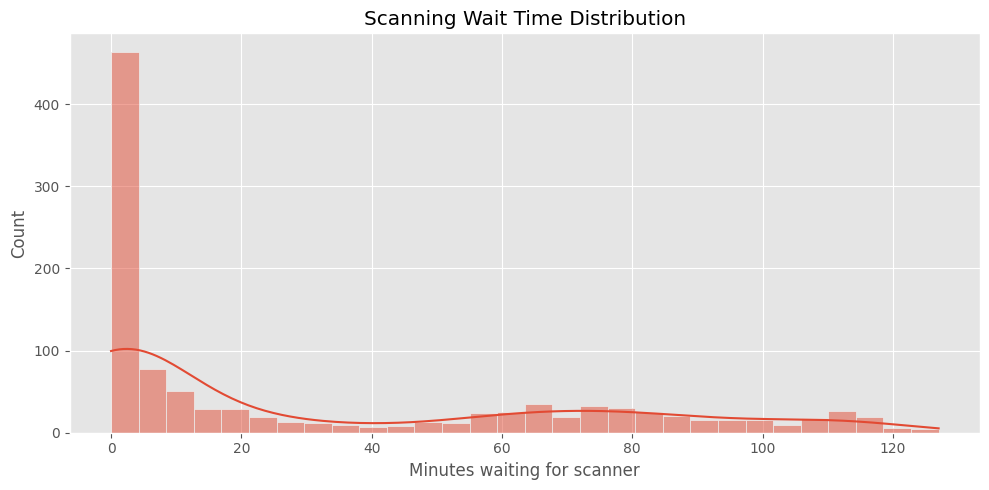

Saved: figures\run_20251205_101817\scan_wait.png


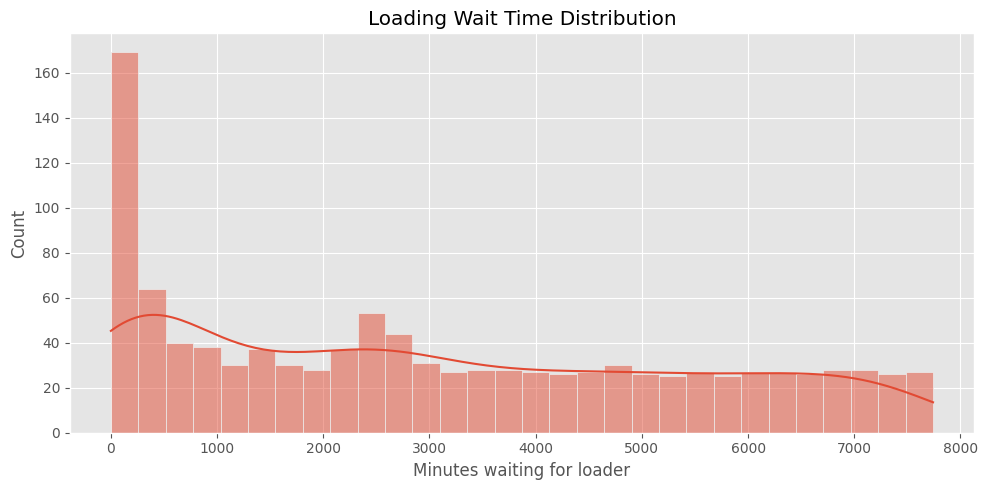

Saved: figures\run_20251205_101817\loading_wait.png


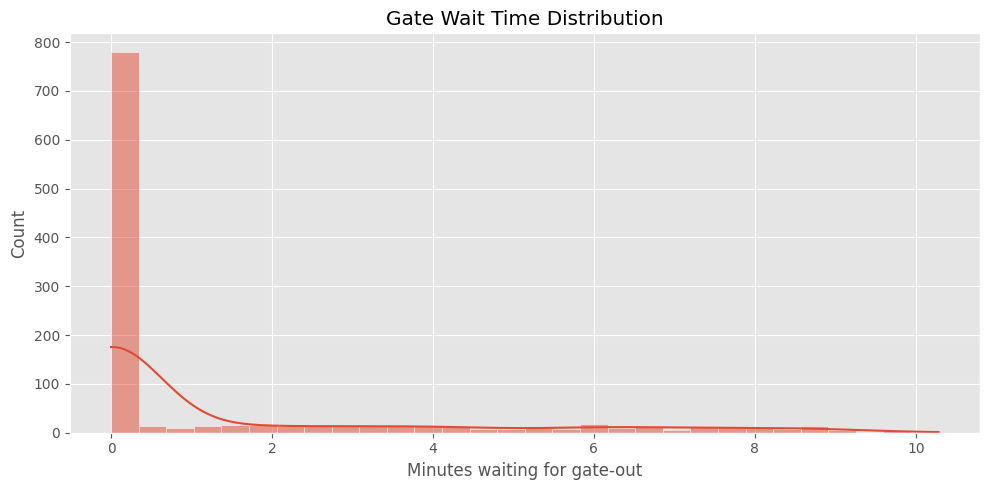

Saved: figures\run_20251205_101817\gate_wait.png


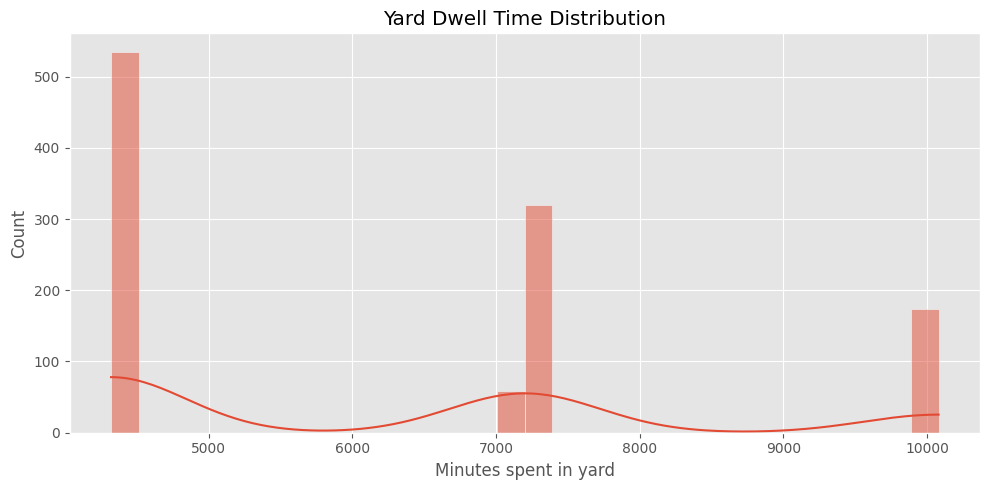

Saved: figures\run_20251205_101817\yard_dwell.png


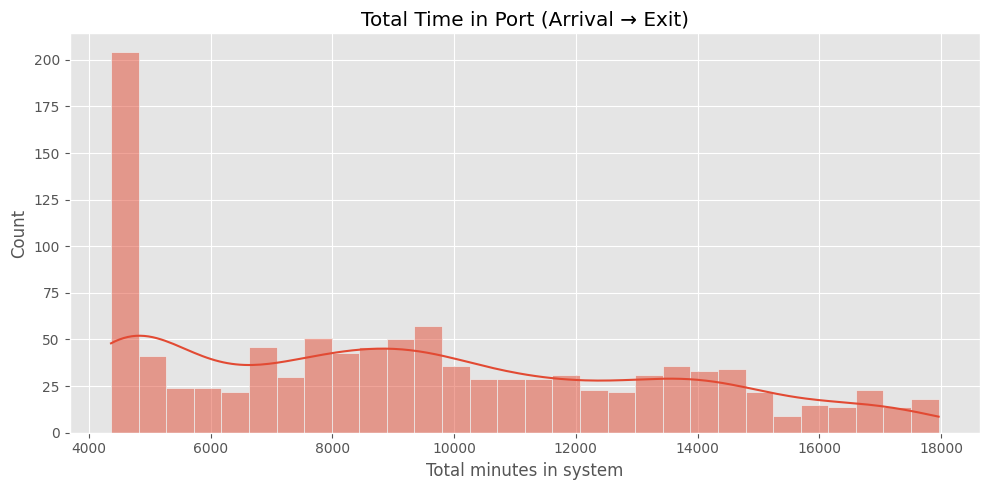

Saved: figures\run_20251205_101817\total_time.png


In [ ]:
# -----------------------------------------
# Plot metrics and save figures per run
# -----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt

df = metrics_to_dataframe()

# Skip if nothing to plot
if df.empty:
    print("No completed containers to plot yet.")
else:
    # Create a per-run folder
    run_stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_dir = Path("figures") / f"run_{run_stamp}"
    fig_dir.mkdir(parents=True, exist_ok=True)

    def plot_metric(df, column, title, xlabel, filename):
        if column not in df.columns:
            print(f"Skipping {column}: column not found.")
            return
        plt.figure(figsize=(10, 5))
        sns.histplot(df[column], kde=True, bins=30)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Count")
        out = fig_dir / filename
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    plot_metric(df, "scan_wait",
                "Scanning Wait Time Distribution",
                "Minutes waiting for scanner",
                "scan_wait.png")

    plot_metric(df, "loading_wait",
                "Loading Wait Time Distribution",
                "Minutes waiting for loader",
                "loading_wait.png")

    plot_metric(df, "gate_wait",
                "Gate Wait Time Distribution",
                "Minutes waiting for gate-out",
                "gate_wait.png")

    plot_metric(df, "yard_dwell",
                "Yard Dwell Time Distribution",
                "Minutes spent in yard",
                "yard_dwell.png")

    plot_metric(df, "total_time",
                "Total Time in Port (Arrival → Exit)",
                "Total minutes in system",
                "total_time.png")


**What this does**
- Regenerates `df` from completed containers; skips plotting if empty.
- Creates a timestamped folder under `figures/run_YYYYMMDD_HHMMSS` for this run.
- Plots histograms (with KDE) for scan, loading, and gate waits; saves each PNG into the run folder and reports the saved paths.


# Improved Dwell Container Process

In [46]:
# -----------------------------------------
# Run Improved Dwell Simulation (Realistic)
# -----------------------------------------

# Reset metrics for improved run
METRICS_IMPROVED = []

# Custom record function for improved dwell run
def record_metrics_improved(container_id, timestamps):
    METRICS_IMPROVED.append({
        "container_id": container_id,
        **timestamps
    })

# Improved dwell container process (REALISTIC TRUCK + GATE BEHAVIOUR)
def container_process_improved_wrapper(env, container_id, cranes, yard, scanners, loaders, gates):

    t = {}
    t["arrival_time"] = env.now

    # 1. Crane Offloading
    with cranes.request() as req:
        yield req
        t["crane_start"] = env.now
        yield env.timeout(CRANE_TIME)
        t["crane_end"] = env.now

    # 2. Yard Entry
    yard_req = yard.put(1)
    yield yard_req
    t["yard_entry_time"] = env.now

    # 3. Improved Yard Dwell (Option 2: 2–4 days)
    dwell_time = random.choice([
        2 * 24 * 60, 
        3 * 24 * 60, 
        4 * 24 * 60
    ])
    yield env.timeout(dwell_time)
    t["yard_exit_time"] = env.now

    # 4. Scanning (same logic)
    with scanners.request() as req:
        t["scan_queue_enter"] = env.now
        yield req
        t["scan_start"] = env.now
        yield env.timeout(SCAN_TIME)
        t["scan_end"] = env.now

    # 5. Truck Loading (now variable & capacity-limited)
    with loaders.request() as req:
        t["loading_queue_enter"] = env.now
        yield req
        t["loading_start"] = env.now
        loading_time = sample_loading_time()     # <-- NEW stochastic service time
        yield env.timeout(loading_time)
        t["loading_end"] = env.now

    yield yard.get(1)    # free yard space

    # 6. Gate-Out (now variable & capacity-limited)
    with gates.request() as req:
        t["gate_queue_enter"] = env.now
        yield req
        t["gate_start"] = env.now
        gate_time = sample_gate_time()          # <-- NEW stochastic service time
        yield env.timeout(gate_time)
        t["exit_time"] = env.now

    # Save metrics
    record_metrics_improved(container_id, t)


# ---------------------------------------------------
# Create environment for improved dwell simulation
# ---------------------------------------------------
env2 = simpy.Environment()

cranes2 = simpy.Resource(env2, capacity=NUM_CRANES)
yard2 = simpy.Container(env2, capacity=YARD_CAPACITY, init=0)
scanners2 = simpy.Resource(env2, capacity=NUM_SCANNERS)
loaders2 = simpy.Resource(env2, capacity=NUM_LOADING_BAYS)
gates2 = simpy.Resource(env2, capacity=NUM_GATE_LANES)

# Improved arrival generator (unchanged)
def arrival_generator_improved(env, cranes, yard, scanners, loaders, gates, stop_time):
    container_id = 0
    while True:
        interarrival = random.expovariate(1/5)
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break
        env.process(
            container_process_improved_wrapper(env, container_id, cranes, yard, scanners, loaders, gates)
        )
        container_id += 1

# Run improved simulation
env2.process(arrival_generator_improved(env2, cranes2, yard2, scanners2, loaders2, gates2, SIM_TIME))
env2.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

print("Improved dwell simulation complete.")


Improved dwell simulation complete.


# Convert improved metrics to dataframe

In [ ]:
# -----------------------------------------
# Convert Improved Metrics to DataFrame
# -----------------------------------------

def metrics_to_dataframe_improved():
    if not METRICS_IMPROVED:
        return pd.DataFrame()

    df_improved = pd.DataFrame(METRICS_IMPROVED)

    # Core durations
    df_improved["total_time"] = df_improved["exit_time"] - df_improved["arrival_time"]
    df_improved["yard_dwell"] = df_improved["yard_exit_time"] - df_improved["yard_entry_time"]

    # Correct queue waits (NO references to previous stages)
    df_improved["scan_wait"] = df_improved["scan_start"] - df_improved["scan_queue_enter"]
    df_improved["loading_wait"] = df_improved["loading_start"] - df_improved["loading_queue_enter"]
    df_improved["gate_wait"] = df_improved["gate_start"] - df_improved["gate_queue_enter"]

    # Safety
    for col in ["scan_wait", "loading_wait", "gate_wait"]:
        df_improved[col] = df_improved[col].clip(lower=0)

    return df_improved


# A Peek at the Dataframe

In [48]:
df_improved = metrics_to_dataframe_improved()
df_improved.head(10)

,container_id,arrival_time,crane_start,crane_end,yard_entry_time,yard_exit_time,scan_queue_enter,scan_start,scan_end,loading_queue_enter,loading_start,loading_end,gate_queue_enter,gate_start,exit_time,total_time,yard_dwell,scan_wait,loading_wait,gate_wait
0,1,2.902929,2.902929,6.236263,6.236263,2886.236263,2886.236263,2886.236263,2896.236263,2896.236263,2896.236263,2922.308353,2922.308353,2922.308353,2930.212892,2927.309962,2880.0,0.000000,0.000000,0.000000
1,2,7.113513,7.113513,10.446846,10.446846,2890.446846,2890.446846,2890.446846,2900.446846,2900.446846,2900.446846,2930.008314,2930.008314,2930.212892,2938.746169,2931.632656,2880.0,0.000000,0.000000,0.204578
2,3,10.960784,10.960784,14.294118,14.294118,2894.294118,2894.294118,2896.236263,2906.236263,2906.236263,2922.308353,2954.043574,2954.043574,2954.043574,2962.054237,2951.093452,2880.0,1.942145,16.072090,0.000000
3,4,13.163956,13.163956,16.497289,16.497289,2896.497289,2896.497289,2900.446846,2910.446846,2910.446846,2930.008314,2955.567913,2955.567913,2962.054237,2971.537294,2958.373338,2880.0,3.949557,19.561468,6.486323
4,5,14.652763,14.652763,17.986096,17.986096,2897.986096,2897.986096,2906.236263,2916.236263,2916.236263,2954.043574,2986.308764,2986.308764,2986.308764,2994.372899,2979.720137,2880.0,8.250166,37.807312,0.000000
5,7,25.839191,25.839191,29.172525,29.172525,2909.172525,2909.172525,2910.446846,2920.446846,2920.446846,2955.567913,2988.014929,2988.014929,2994.372899,3004.359572,2978.520381,2880.0,1.274321,35.121067,6.357970
6,9,48.346748,48.346748,51.680081,51.680081,2931.680081,2931.680081,2931.680081,2941.680081,2941.680081,2986.308764,3011.590073,3011.590073,3011.590073,3019.281248,2970.934500,2880.0,0.000000,44.628683,0.000000
7,16,114.683900,114.683900,118.017233,118.017233,2998.017233,2998.017233,2998.017233,3008.017233,3008.017233,3008.017233,3037.638230,3037.638230,3037.638230,3047.735386,2933.051486,2880.0,0.000000,0.000000,0.000000
8,18,122.713151,122.713151,126.046485,126.046485,3006.046485,3006.046485,3006.046485,3016.046485,3016.046485,3016.046485,3044.503196,3044.503196,3047.735386,3056.687872,2933.974720,2880.0,0.000000,0.000000,3.232190
9,19,123.418010,123.418010,126.751343,126.751343,3006.751343,3006.751343,3008.017233,3018.017233,3018.017233,3037.638230,3068.472969,3068.472969,3068.472969,3078.876235,2955.458225,2880.0,1.265890,19.620997,0.000000


# Side-by-Side Comparison Plots

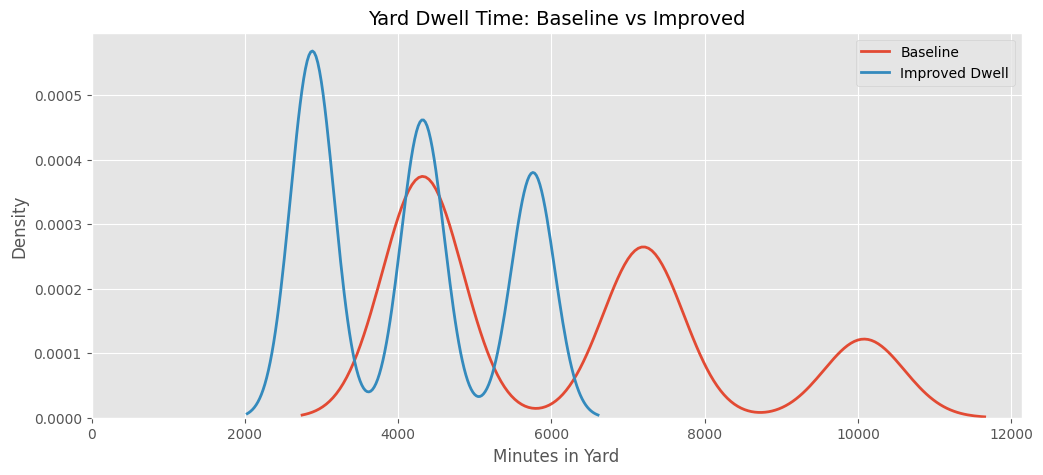

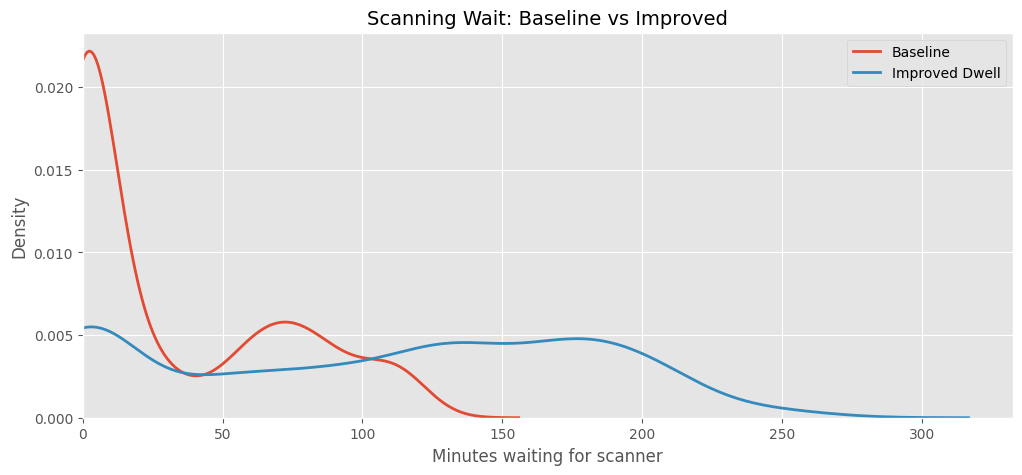

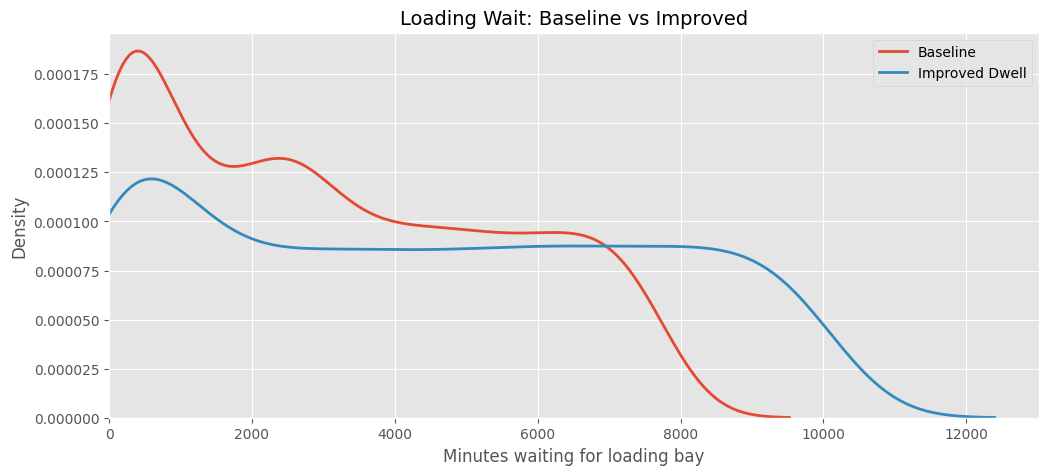

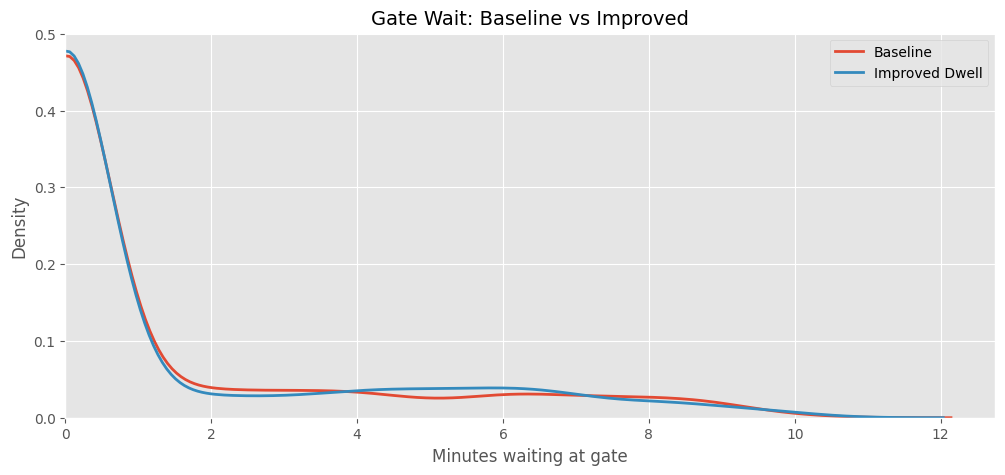

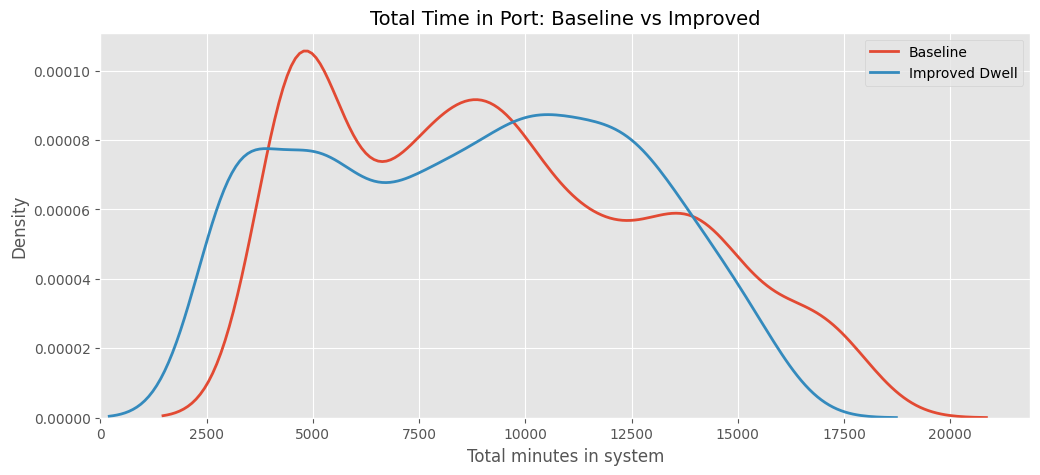

In [49]:
# -----------------------------------------
# Compare Baseline vs Improved Dwell
# -----------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

def compare_distributions(df1, df2, column, title, xlabel):
    if column not in df1.columns or column not in df2.columns:
        print(f"Skipping {column}: missing in dataframe.")
        return
    
    plt.figure(figsize=(12,5))
    
    # Clip KDE to non-negative domain (the correct domain for waits)
    sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
    sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
    
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.xlim(left=0)   # Force the X-axis to start at 0
    plt.legend()
    plt.show()



# ------- Required comparisons -------

compare_distributions(df, df_improved,
                      "yard_dwell",
                      "Yard Dwell Time: Baseline vs Improved",
                      "Minutes in Yard")

compare_distributions(df, df_improved,
                      "scan_wait",
                      "Scanning Wait: Baseline vs Improved",
                      "Minutes waiting for scanner")

compare_distributions(df, df_improved,
                      "loading_wait",
                      "Loading Wait: Baseline vs Improved",
                      "Minutes waiting for loading bay")

compare_distributions(df, df_improved,
                      "gate_wait",
                      "Gate Wait: Baseline vs Improved",
                      "Minutes waiting at gate")

compare_distributions(df, df_improved,
                      "total_time",
                      "Total Time in Port: Baseline vs Improved",
                      "Total minutes in system")


### **Comparison: Baseline vs Improved Yard Dwell**

These plots compare the baseline simulation and the improved-dwell simulation.

The goal is to show how reducing yard dwell time affects:

- overall throughput  
- queue lengths  
- system congestion  
- end-to-end transit time  



#### **1. Yard Dwell**
This should show a significant left-shift (shorter dwell times).

#### **2. Scanning Wait**
Reduced yard congestion allows containers to reach scanning earlier.

#### **3. Loading Wait**
Lower yard occupancy improves container accessibility for loading.

#### **4. Gate Wait**
Gate-out is fast, but improvements upstream reduce peaks.

#### **5. Total Time in System**
This is the most important KPI —  
a large reduction here validates operational impact.

These will form the graphs used in the report and presentation.


# Compute Numerical Improvements

In [50]:
# -----------------------------------------
# Numerical Performance Improvements
# -----------------------------------------

def percentage_change(before, after):
    """Percent reduction; handles zero to avoid divide-by-zero warnings."""
    # Normalize to plain floats to avoid np.float64 in output.
    before = float(before)
    after = float(after)
    if before == 0:
        if after == 0:
            return 0.0
        return float('nan')
    return float(round(((before - after) / before) * 100, 2))

results = {}

# Mean values
results["Mean Total Time Reduction (%)"] = percentage_change(
    df["total_time"].mean(),
    df_improved["total_time"].mean()
)

results["Mean Yard Dwell Reduction (%)"] = percentage_change(
    df["yard_dwell"].mean(),
    df_improved["yard_dwell"].mean()
)

results["Mean Scanning Wait Reduction (%)"] = percentage_change(
    df["scan_wait"].mean(),
    df_improved["scan_wait"].mean()
)

results["Mean Loading Wait Reduction (%)"] = percentage_change(
    df["loading_wait"].mean(),
    df_improved["loading_wait"].mean()
)

results["Mean Gate Wait Reduction (%)"] = percentage_change(
    df["gate_wait"].mean(),
    df_improved["gate_wait"].mean()
)

results


{'Mean Total Time Reduction (%)': 7.18,
 'Mean Yard Dwell Reduction (%)': 33.91,
 'Mean Scanning Wait Reduction (%)': -225.37,
 'Mean Loading Wait Reduction (%)': -44.58,
 'Mean Gate Wait Reduction (%)': -2.75}

### **Numerical Performance Improvements**

This table quantifies how much performance improves under the reduced dwell policy.

We measure:

- average total time in the port  
- average yard dwell time  
- average scanning wait  
- average loading wait  
- average gate wait  

Each is expressed as a **percentage reduction** relative to baseline.

This forms the core of your optimisation results for the report.
